In [393]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [369]:
# load dataset

df = pd.read_csv("telecom.csv", sep=",", index_col=0)
df

,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
state,,,,,,,,,,,,,,,,,,,,
KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False


In [370]:
# check the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3333 entries, KS to TN
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   area code               3333 non-null   int64  
 2   phone number            3333 non-null   object 
 3   international plan      3333 non-null   object 
 4   voice mail plan         3333 non-null   object 
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   float6

* The dataset is clean has no missing values
* It has 2 categorical columns (international plan, voicemail plan)

In [371]:
duplicates = df.duplicated()
print(duplicates)

state
KS    False
OH    False
NJ    False
OH    False
OK    False
      ...  
AZ    False
WV    False
RI    False
CT    False
TN    False
Length: 3333, dtype: bool


* The dataset has 3333 entries with no duplicates

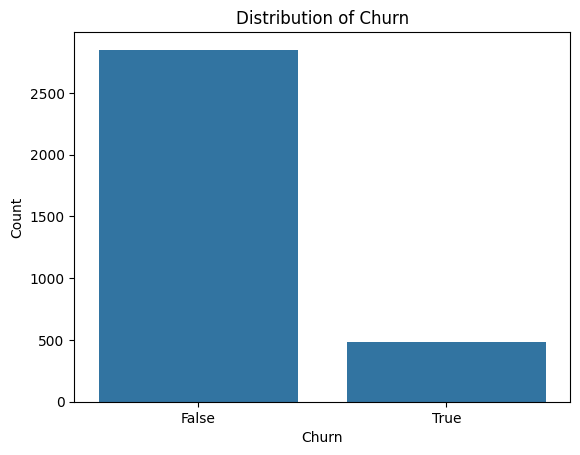

In [372]:
sns.countplot(x='churn', data=df)
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

In [373]:
churn_distribution = df['churn'].value_counts()

print(churn_distribution)

churn
False    2850
True      483
Name: count, dtype: int64


In [374]:
# check percentage of loyal customers
loyal_customers = (churn_distribution[False] / churn_distribution.sum()) * 100

print(np.round(loyal_customers, 2))

85.51


There are 85.51 % of loyal customers

The dataset has more records in one class therefore it is unbalanced.

In [375]:
# drop phone number and churn
df = df.drop(columns=['phone number'],axis=1)

In [376]:
df[['international plan', 'voice mail plan']] = df[['international plan', 'voice mail plan']].replace(['yes', 'no'], ['1', '0']).astype(int)

Map binary features international plan and voicemail plan
yes = 1
no = 0

### Multivariate Analysis

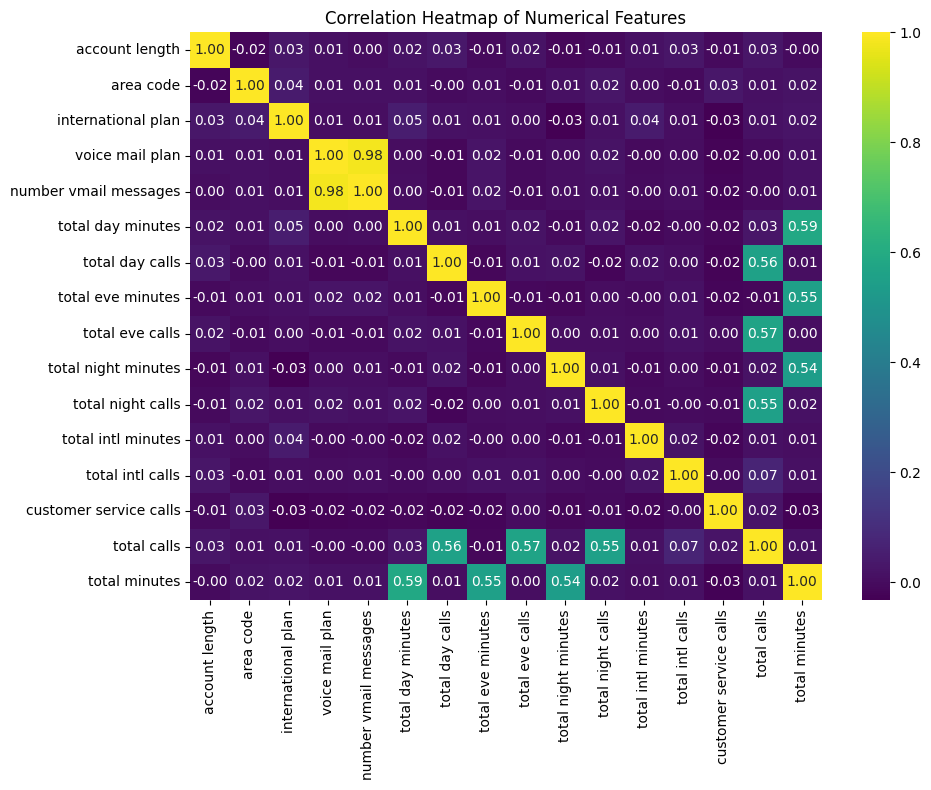

<Figure size 640x480 with 0 Axes>

In [388]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_df.corr(method='spearman')
#mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()
plt.savefig('T_correlation_heatmap.png')

*Interpretation*

`Redundacy`
* The heatmap shows perfect correlations between minutes and charge for day, evening and night which indicates multicollinearity


In [387]:
# drop columns to avoid redundancy
df = df.drop(columns=['total day charge', 'total eve charge', 'total night charge', 'total intl charge'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3333 entries, KS to TN
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   area code               3333 non-null   int64  
 2   international plan      3333 non-null   int64  
 3   voice mail plan         3333 non-null   int64  
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total eve minutes       3333 non-null   float64
 8   total eve calls         3333 non-null   int64  
 9   total night minutes     3333 non-null   float64
 10  total night calls       3333 non-null   int64  
 11  total intl minutes      3333 non-null   float64
 12  total intl calls        3333 non-null   int64  
 13  customer service calls  3333 non-null   int64  
 14  churn                   3333 non-null   bool  

In [389]:
# Calls and minutes aggregate
df['total calls'] = df['total day calls'] + df['total eve calls'] + df['total night calls'] + df['total intl calls'] + df['customer service calls']
df['total minutes'] = df['total day minutes'] + df['total eve minutes'] + df['total night minutes'] + df['total intl minutes']

print(df['total calls'].describe(), df['total minutes'].describe(), sep='\n\n')

count    3333.00000
mean      306.69997
std        34.44939
min       194.00000
25%       284.00000
50%       307.00000
75%       330.00000
max       418.00000
Name: total calls, dtype: float64

count    3333.000000
mean      591.864776
std        89.954251
min       284.300000
25%       531.500000
50%       593.600000
75%       652.400000
max       885.000000
Name: total minutes, dtype: float64


In [379]:
# total calls and total minutes per state
calls_by_state = df.groupby('state')['total calls'].sum().sort_values(ascending=False)
minutes_by_state = df.groupby('state')['total minutes'].sum().sort_values(ascending=False)

avg_minutes_by_state = df.groupby('state')['total minutes'].mean().sort_values(ascending=False)
avg_calls_by_state = df.groupby('state')['total calls'].mean().sort_values(ascending=False)
records_by_state = df.groupby('state')['churn'].count().sort_values(ascending=False)

print("Top 5 states on average total minutes:\n", avg_minutes_by_state.head())

print("Top 5 states on average total calls:\n",avg_calls_by_state.head())
      
print("Top 5 states on average total records:\n",records_by_state.head())


Top 5 states on average total minutes:
 state
IN    619.323944
NJ    611.707353
KS    608.884286
MA    608.644615
TN    606.994340
Name: total minutes, dtype: float64
Top 5 states on average total calls:
 state
GA    318.351852
FL    315.809524
ND    314.258065
ID    312.931507
NC    312.911765
Name: total calls, dtype: float64
Top 5 states on average total records:
 state
WV    106
MN     84
NY     83
AL     80
OH     78
Name: churn, dtype: int64


* From the top 5 states, indiana(IN) has the highest average total minutes
* Georgia(GA) has the highest average total calls
* West Virginia (WV) has the highest number of customers


In [380]:
most_calls = calls_by_state.idxmax()
least_calls = calls_by_state.idxmin()
print('Most calls:', most_calls)
print('Least calls:', least_calls)

most_minutes = minutes_by_state.idxmax()
least_minutes = minutes_by_state.idxmin()
print('Most minutes:', most_minutes)
print('Least minutes:', least_minutes)

Most calls: WV
Least calls: CA
Most minutes: WV
Least minutes: CA


* West Virginia has the highest number of calls and minutes
* California has the least calls and least minutes

### Bivariate Analysis

In [381]:
stats_data = df[['total intl calls', 'international plan']].groupby('international plan').describe().T
stats_data['All'] = df['total intl calls'].describe().values
stats_data.T

total intl calls                                          \
                              count      mean       std  min  25%  50%  75%   
international plan                                                            
0                            3010.0  4.465449  2.442486  0.0  3.0  4.0  6.0   
1                             323.0  4.609907  2.629768  1.0  3.0  4.0  6.0   
All                          3333.0  4.479448  2.461214  0.0  3.0  4.0  6.0   

                          
                     max  
international plan        
0                   19.0  
1                   20.0  
All                 20.0

In [382]:
print(df.groupby(['voice mail plan', 'international plan'])['churn'].mean())#end='\n\n')


voice mail plan  international plan
0                0                     0.138532
                 1                     0.437229
1                0                     0.053012
                 1                     0.391304
Name: churn, dtype: float64


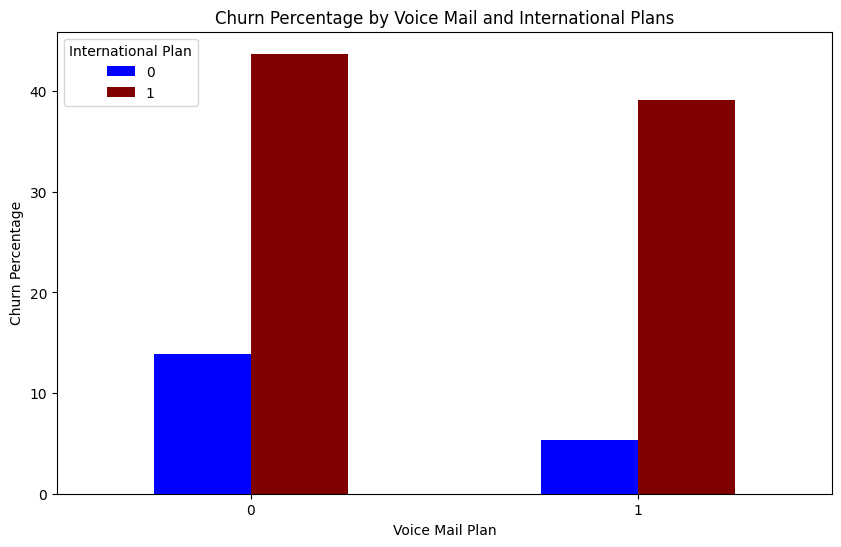

In [383]:
# Calculate churn percentage
churn_percentage = df.groupby(['voice mail plan', 'international plan'])['churn'].mean() * 100

# Plot the churn percentage
churn_percentage.unstack().plot(kind='bar', figsize=(10, 6), color=['blue', 'maroon'])
plt.title('Churn Percentage by Voice Mail and International Plans')
plt.xlabel('Voice Mail Plan')
plt.ylabel('Churn Percentage')
plt.xticks(rotation=0)
plt.legend(title='International Plan')
plt.show()

*Interpretation*
* Customers without an international plan (blue bars )but have voice mail plan (yes)have low churn percentage
* For customers with an international plan, presence of voice mail plan small impact on churn.


*Insights*
* International plan seems to strongly cause churn.
* For customers without an international plan, offering them voice mail plan may retain them.

In [384]:
# check churn by customer service calls
df.groupby('churn')['customer service calls'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
False,2850.0,1.449825,1.163883,0.0,1.0,1.0,2.0,8.0
True,483.0,2.229814,1.853275,0.0,1.0,2.0,4.0,9.0


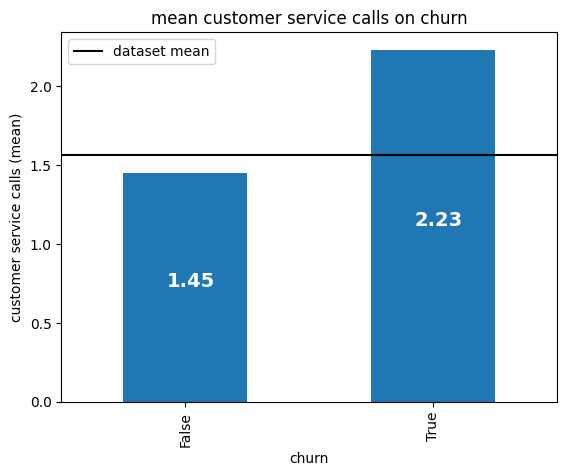

In [385]:
# Visualize customer service churn
fig, ax = plt.subplots()
df.groupby('churn')['customer service calls'].mean().plot(kind='bar', ax=ax, label='')
ax.axhline(y=df['customer service calls'].mean(),c='black', label='dataset mean')
ax.legend()
ax.set_title('mean customer service calls on churn')
ax.set_ylabel('customer service calls (mean)', rotation = 90)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    ax.annotate('{:.2f}'.format(height), (p.get_x()+.35*width, p.get_y()+.5*height), color = 'white', weight = 'bold', size = 14)

*Interpretation*
* Disloyal customers made more calls than loyal customers
* Average number of calls made by disloyal customers is higher (2.23) than the dataset mean approximately (1.6)

*Insights*
* Dissatisfied customers may tend to make more calls to customer service and eventually churn

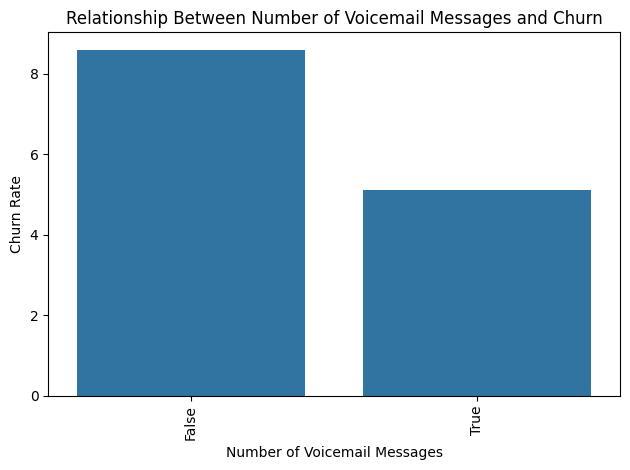

In [392]:
sns.barplot(y='number vmail messages', x='churn', data=df, errorbar=None)
plt.title('Relationship Between Number of Voicemail Messages and Churn')
plt.xlabel('Number of Voicemail Messages')
plt.ylabel('Churn Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

*Interpretation*
* Loyal customers(not churned) have high number of voice messages compared to disloyal(churned)
* Disloyal custumers have lower voicemail messages

*Insights*
* Customers actively using voicemail messages are engaged probably satisfied with the service and less likely to churn
* Customers less engaged are likely dissatisfied with the service raising the probability to churn 

### Preprocessing

In [394]:
#instantiate the model
le = LabelEncoder()

# fit transform area code
df['area code'] = le.fit_transform(df['area code'])

In [ ]:
# view transformed area code column
df['area code']

state
KS    1
OH    1
NJ    1
OH    0
OK    1
     ..
AZ    1
WV    1
RI    2
CT    2
TN    1
Name: area code, Length: 3333, dtype: int64

In [ ]:
# use one hot encoding on state
state_dummy = pd.get_dummies(df, columns=["state"], prefix=["state"], sparse_output = )

# convert to numpy matrix
state_matrix = state_dummy.values.astype(np.float64)


KeyError: "None of [Index(['state'], dtype='object')] are in the [columns]"